In [123]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time

In [124]:
import hackeeg
from hackeeg import ads1299
import keyboard

In [125]:
SERIAL_PORT_PATH = "/dev/cu.usbmodem143301"
SAMPLES_PER_SECOND = ads1299.HIGH_RES_1k_SPS
GAIN = ads1299.GAIN_4X
CHANNELS = 8

In [126]:
# Configure ADS1299
hackeeg = hackeeg.HackEEGBoard(serial_port_path=SERIAL_PORT_PATH)
hackeeg.connect()
hackeeg.blink_board_led()
hackeeg.sdatac()
hackeeg.reset()
hackeeg.disable_all_channels()

# Set sampling rate
hackeeg.wreg(ads1299.CONFIG1, SAMPLES_PER_SECOND | ads1299.CONFIG1_const)

hackeeg.enable_all_channels()
for i in range(1, 9):
    hackeeg.wreg(ads1299.CHnSET + i, ads1299.ELECTRODE_INPUT | GAIN)

# Bipolar mode - each channel is the differential voltage between adjacent electrodes
# hackeeg.wreg(ads1299.MISC1, ads1299.MISC1_const)
# For unipolar mode, uncomment the following line to set the SRB1 bit,
# which sends mid-supply voltage to the N inputs
hackeeg.wreg(ads1299.MISC1, ads1299.SRB1 | ads1299.MISC1_const)

hackeeg.messagepack_mode()

SerialException: [Errno 2] could not open port /dev/cu.usbmodem143301: [Errno 2] No such file or directory: '/dev/cu.usbmodem143301'

In [ ]:
# Read data continuously for 5 seconds
hackeeg.blink_board_led()
hackeeg.start()
hackeeg.rdatac()

print("Flex!")

samples = []
timestamp_contraction = []
t_end = time.time() + 5
while time.time() < t_end:
    result = hackeeg.read_rdatac_response()
    if result:
        samples.append(result)
        if keyboard.is_pressed('space'):
            timestamp_contraction.append(result.get('timestamp'))
    else:
        print("no data to decode")
        print(f"result: {result}")

print("Sampling complete")

Flex!
Sampling complete


In [ ]:
# Process samples

channel_data = np.empty((9, len(samples)))
for i, s in enumerate(samples):
    dataKey = s.get(hackeeg.MpDataKey)
    if dataKey:
        timestamp = s.get('timestamp')
        data = s.get('channel_data')
        channel_data[0, i] = timestamp
        for channel in range(1,9):
            channel_data[channel, i] = data[channel-1]

print(channel_data)
channel_data = channel_data.astype(np.float64)
np.save('channel_data', channel_data)

# Sampled in bipolar mode; -2.5V - +2.5V
# 24-bit resolution ADC
# analog voltage measured = (ADC reading * system voltage) / resolution
analog_voltage = (channel_data[1:] * 2.5) / (2**23)
print(analog_voltage)

[[25896701. 25897417. 25898418. ... 30843719. 30844717. 30845716.]
 [-7558697. -7522982. -7479063. ... -7568386. -7510829. -7424884.]
 [-8388608. -8160236. -7804299. ... -7823787. -7379592. -6767705.]
 ...
 [-8388608. -8388608. -8121372. ... -8074070. -7593151. -6932449.]
 [-8337961. -8052972. -7733331. ... -7720677. -7316434. -6758702.]
 [-7534296. -7455745. -7365289. ... -7429088. -7310214. -7141621.]]
[[-2.25266725 -2.24202335 -2.22893447 ... -2.2555548  -2.23840147
  -2.21278787]
 [-2.5        -2.43193984 -2.32586235 ... -2.33167022 -2.1992898
  -2.01693326]
 [-2.5        -2.42760837 -2.3180297  ... -2.3053962  -2.16355145
  -1.96855575]
 ...
 [-2.5        -2.5        -2.42035747 ... -2.40626037 -2.26293534
  -2.0660308 ]
 [-2.48490602 -2.39997268 -2.30471224 ... -2.30094105 -2.18046725
  -2.01425016]
 [-2.24539518 -2.22198516 -2.19502717 ... -2.21404076 -2.17861354
  -2.12836891]]


In [134]:
data = np.load('channel_data.npy')
analog_voltage = (data[1:] * 2.5) / (2**23)
timestamps = data[0]

Text(0.5, 1.0, 'FFT of signal')

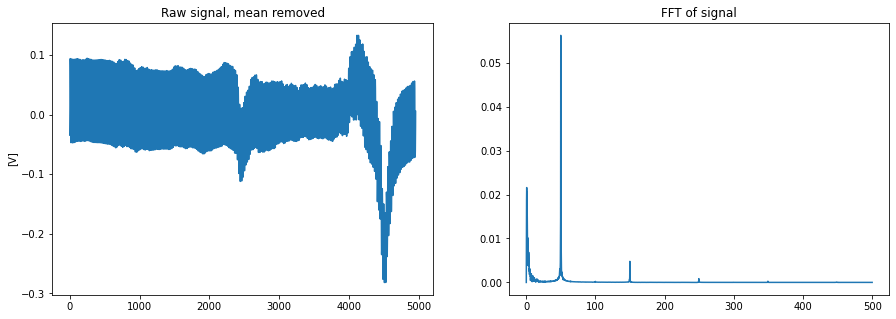

In [199]:
import scipy
from scipy import fftpack
sampling_rate = 1000

N = len(analog_voltage[0])
T = 1 / sampling_rate
x = np.linspace(0.0, 1.0/(2.0*T), N//2)
y = analog_voltage[0]
y = y - y.mean()

y_fft = scipy.fftpack.fft(y)

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(y)
plt.title('Raw signal, mean removed')
plt.ylabel('[V]')
plt.subplot(1, 2, 2)
plt.plot(x, 2.0/N * np.abs(y_fft[:N//2]))
plt.title('FFT of signal')



 The argument 'scale_y' is depreciated and will be                         removed in a future version. Please use 'sharey' to remove this                         warning


<AxesSubplot:xlabel='Time (samples)'>

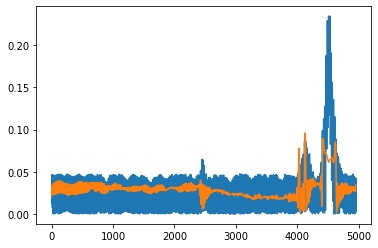

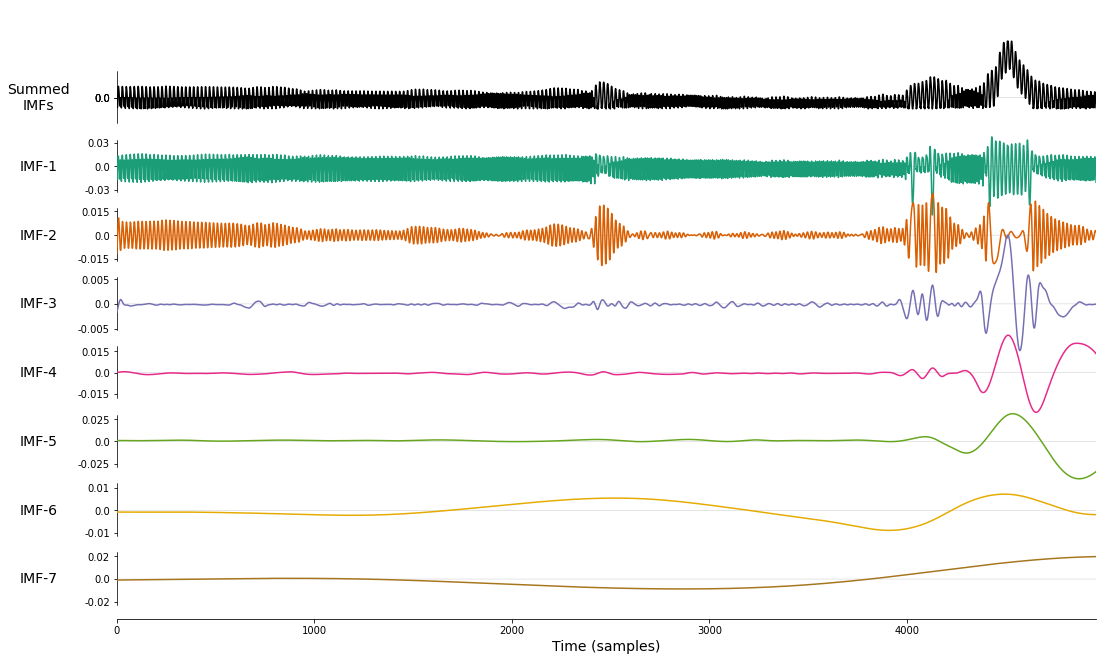

In [136]:
# EMD
import emd
seconds = 5
num_samples = seconds*sampling_rate

imf = emd.sift.sift(y - y.mean())
envelope = emd.sift.interp_envelope(imf, mode='upper')

plt.plot(abs(y-y.mean()))
plt.plot(envelope)
emd.plotting.plot_imfs(imf, scale_y=True, cmap=True)

Text(0.5, 1.0, 'FFT after bandpass filtering')

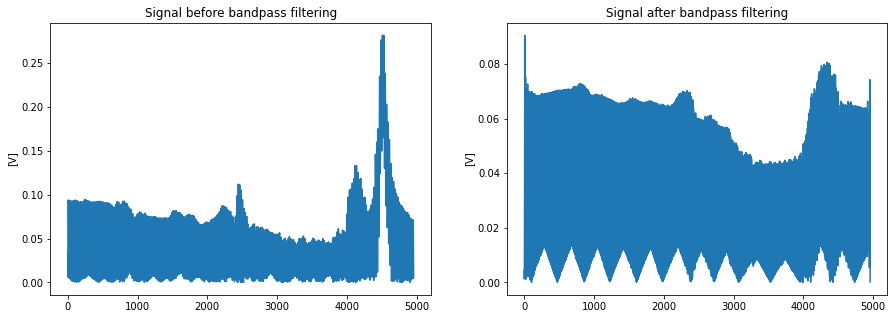

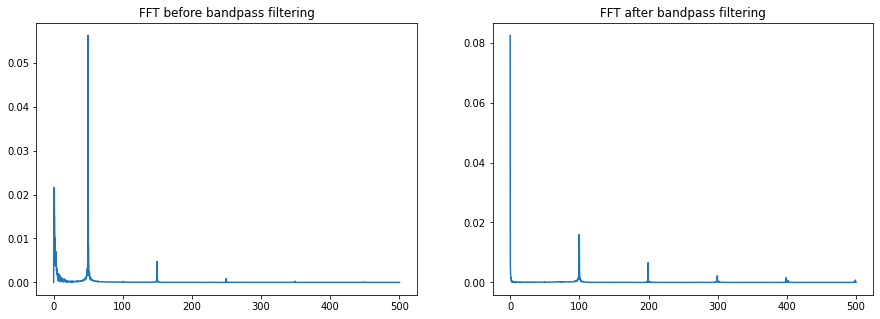

In [200]:
# Bandpass filter
high = 20/(sampling_rate/2)         # Normalized to Nyquist rate
low = 450/(sampling_rate/2)
b, a = scipy.signal.butter(4, [high,low], btype='bandpass')
y_butter = scipy.signal.filtfilt(b, a, y)
y_butter = abs(y_butter)

y_butter_fft = scipy.fftpack.fft(y_butter)

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(abs(y))
plt.title('Signal before bandpass filtering')
plt.ylabel('[V]')
plt.subplot(1, 2, 2)
plt.plot(y_butter)
plt.title('Signal after bandpass filtering')
plt.ylabel('[V]')

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(x, 2.0/N * np.abs(y_fft[:N//2]))
plt.title('FFT before bandpass filtering')
plt.subplot(1, 2, 2)
plt.plot(x, 2.0/N * np.abs(y_butter_fft[:N//2]))
plt.title('FFT after bandpass filtering')


Text(0.5, 1.0, 'FFT after notch filtering')

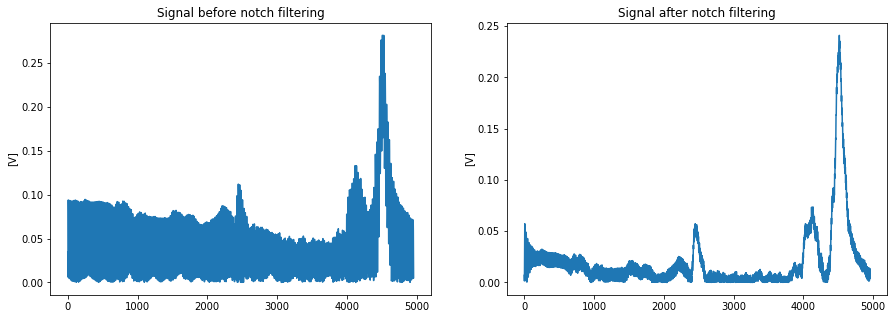

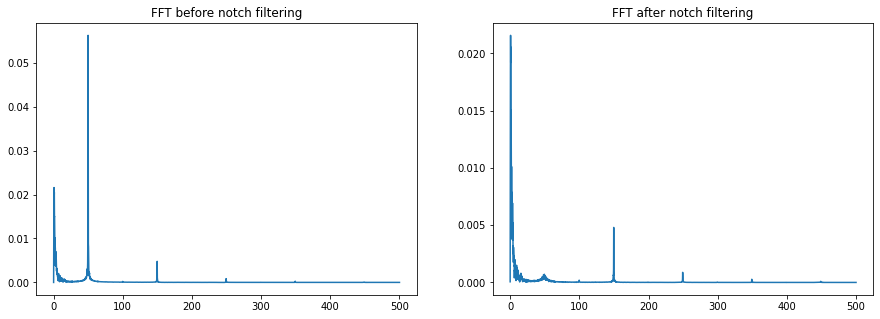

In [201]:
# Notch filter
notch_freq = 50.0     # Frequency to be removed from signal (Hz)
quality_factor = 10.0
b_notch, a_notch = scipy.signal.iirnotch(notch_freq, quality_factor, sampling_rate)

freq, h = scipy.signal.freqz(b_notch, a_notch, fs=sampling_rate)
y_notched = scipy.signal.filtfilt(b_notch, a_notch, y)
y_notched_fft = scipy.fftpack.fft(y_notched)

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(abs(y))
plt.title('Signal before notch filtering')
plt.ylabel('[V]')
plt.subplot(1, 2, 2)
plt.plot(abs(y_notched))
plt.title('Signal after notch filtering')
plt.ylabel('[V]')

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(x, 2.0/N * np.abs(y_fft[:N//2]))
plt.title('FFT before notch filtering')
plt.subplot(1, 2, 2)
plt.plot(x, 2.0/N * np.abs(y_notched_fft[:N//2]))
plt.title('FFT after notch filtering')

Text(0, 0.5, '[V]')

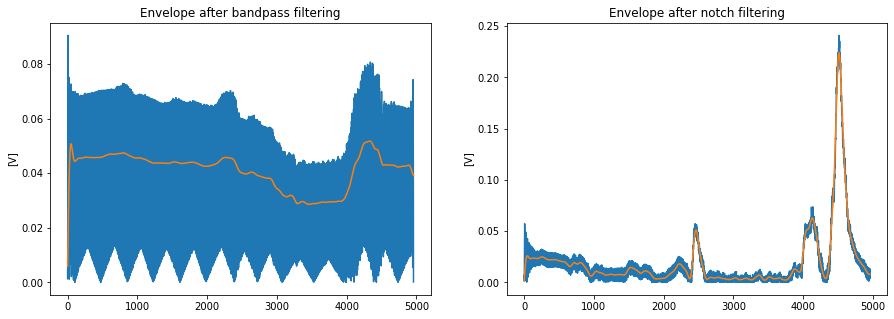

In [202]:
# Envelope
low_pass = 10/(sampling_rate/2)
b, a = scipy.signal.butter(3, low_pass, btype='lowpass')
envelope_b = scipy.signal.filtfilt(b, a, abs(y_butter))
envelope_n = scipy.signal.filtfilt(b, a, abs(y_notched))

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(abs(y_butter))
plt.plot(envelope_b)
plt.title('Envelope after bandpass filtering')
plt.ylabel('[V]')
plt.subplot(1, 2, 2)
plt.plot(abs(y_notched))
plt.plot(envelope_n)
plt.title('Envelope after notch filtering')
plt.ylabel('[V]')

 The argument 'scale_y' is depreciated and will be                         removed in a future version. Please use 'sharey' to remove this                         warning


<AxesSubplot:xlabel='Time (samples)'>

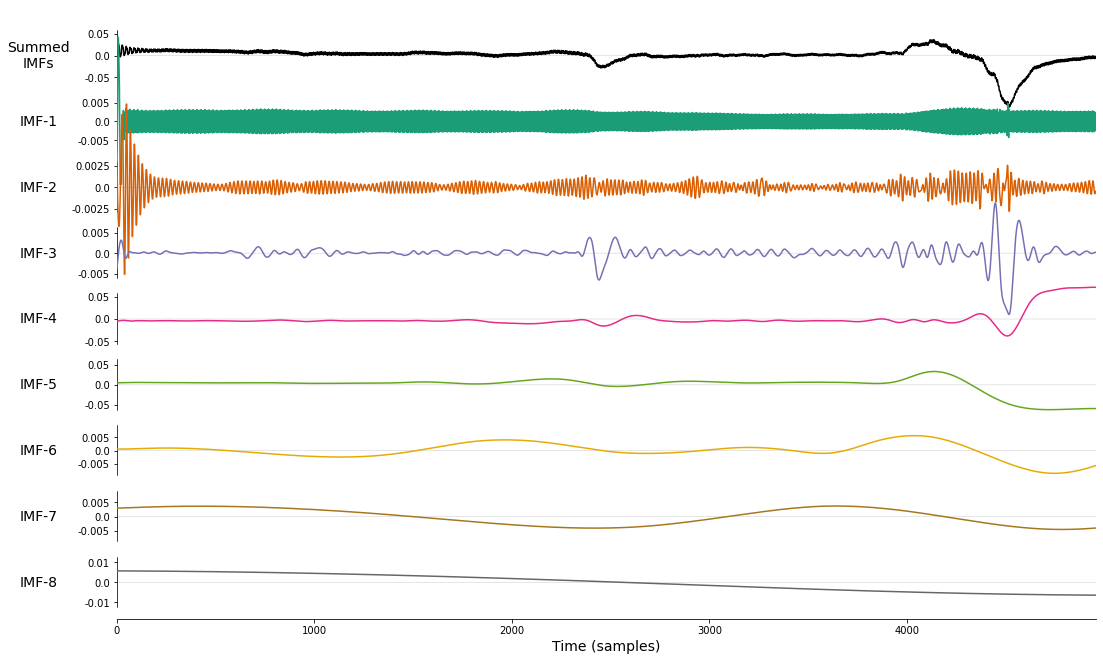

In [130]:
imf = emd.sift.sift(y_notched)
emd.plotting.plot_imfs(imf, scale_y=True, cmap=True)